In [40]:
import pandas as pd
import gensim.models.keyedvectors as word2vec
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [9]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [10]:
df = pd.read_csv("./word2vec.csv",header=0, keep_default_na=False)
#df = pd.read_csv("./word2vec_debiased.csv",header=0, keep_default_na=False)
model =  word2vec.KeyedVectors.load_word2vec_format('./word2vec_50k.bin', binary=True)

In [11]:
df.head()

,word
0,prison
1,agony
2,vomit
3,rotten
4,cancer


In [13]:
# calculate bias direction when we have group of words not pairs
def groupBiasDirection(gp1, gp2):
    print(gp1,gp2)
    dim = len(model["he"])
    g1,g2 = np.zeros((dim,), dtype=float), np.zeros((dim,), dtype=float)
    for p in gp1:
        p = p.strip()
        if p not in model:
            continue
        p_vec = model[p]/norm(model[p])
        g1 = np.add(g1,p_vec)

    for q in gp2:
        q = q.strip()
        if q not in model:
            continue
        q_vec = model[q]/norm(model[q])
        g2 = np.add(g2,q_vec) 

    g1, g2 = g1/norm(g1), g2/norm(g2)
    return (g1,g2)

In [14]:
gender_bias = [("he","him","boy"),("she","her","girl")]
eco_bias = [("rich","wealthy"),("poor","impoverished")]
race_bias = [("african","black"),("european","white")]

In [15]:
g1,g2 = groupBiasDirection(gender_bias[0], gender_bias[1])
g3,g4 = groupBiasDirection(eco_bias[0], eco_bias[1])
g5,g6 = groupBiasDirection(race_bias[0], race_bias[1])

('he', 'him', 'boy') ('she', 'her', 'girl')
('rich', 'wealthy') ('poor', 'impoverished')
('african', 'black') ('european', 'white')


<h2>Simple MDS plot from word embedding</h2>

In [39]:
subset_words = ["teacher", "soldier", "manager", "lecturer", "dancer", "joy", "love", "acid"]
vec = {}
for w in subset_words:
    vec[w] = model[w]/norm(model[w])
vec["Male"] = g1
vec["Female"] = g2

In [41]:
sparse = sparse.csr_matrix(np.array(list(vec.values())))
dis_mat = cosine_similarity(sparse)

In [46]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
points = mds.fit_transform(dis_mat)

In [47]:
points

array([[-0.16386867, -0.12943594],
       [-0.03776773,  0.06545791],
       [-0.00050015, -0.00322398],
       [ 0.0722262 ,  0.0804362 ],
       [ 0.11401966, -0.06204463],
       [ 0.08253966,  0.02111157],
       [-0.1276391 , -0.01012687],
       [ 0.01004059, -0.00856615],
       [ 0.06991582, -0.18895235],
       [-0.01896628,  0.23534424]])

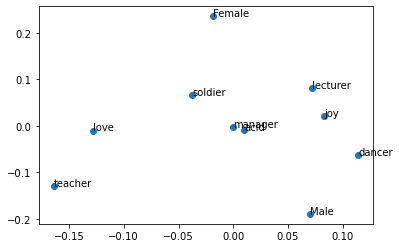

In [48]:
x = points[:,0]
y = points[:,1]
marker = list(vec.keys())

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(marker):
    ax.annotate(txt, (x[i], y[i]))

<h2></h2>

In [8]:
df["semantic"] = None # encode semantic meaning by projecting to principal component
df["gender"] = None
df["eco"] = None
df["race"] = None

In [9]:
# calculaue principal component
matrix = []
for w in df["word"].tolist():
    matrix.append(model[w])
matrix = np.array(matrix)
pca = PCA(n_components=2)
pca.fit(matrix)
g = pca.components_[0]

In [11]:
words = df["word"].tolist()
for index, row in df.iterrows():
    w = row["word"]
    df.at[index, "gender"] = round(cosine(g1,model[w])-cosine(g2,model[w]),4)
    df.at[index, "eco"] = round(cosine(g3,model[w])-cosine(g4,model[w]),4)
    df.at[index, "race"] = round(cosine(g5,model[w])-cosine(g6,model[w]),4)
    df.at[index, "semantic"] = round(cos_sim(g,model[w]),5) 

In [12]:
df.head()

,word,semantic,gender,eco,race
0,prison,0.16643,-0.0591,0.1214,0.0044
1,agony,-0.05577,-0.0026,0.0982,-0.0137
2,vomit,0.12755,0.0063,0.0706,0.0512
3,rotten,-0.11532,-0.0595,0.1722,0.0205
4,cancer,0.21135,0.0437,-0.0243,-0.0257


In [13]:
df = df.sort_values('semantic')
df = df[['word','gender','eco','race']]

In [14]:
gen_max, gen_min = df["gender"].max(), df["gender"].min()
eco_max, eco_min = df["eco"].max(), df["eco"].min()
race_max, race_min = df["race"].max(), df["race"].min()
print("Gender: ",gen_min,gen_max)
print("Eco: ",eco_min, eco_max)
print("Race: ",race_min, race_max)

Gender:  -0.3903 0.4015
Eco:  -0.453 0.4662
Race:  -0.1999 0.1428


In [34]:
# normalization of bias scores
for index, row in df.iterrows():
    if row["gender"]>0:
        df.set_value(index, "gender", row["gender"]/gen_max)
    else:
        df.set_value(index, "gender", -1*row["gender"]/gen_min)
        
    if row["race"]>0:
        df.set_value(index, "race", row["race"]/race_max)
    else:
        df.set_value(index, "race", -1*row["race"]/race_min)
    
    if row["eco"]>0:
        df.set_value(index, "eco", row["eco"]/eco_max)
    else:
        df.set_value(index, "eco", -1*row["eco"]/eco_min)

In [35]:
df.head()

,word,gender,eco,race
9629,unimpressed,-0.0950551,0.191334,0.401961
4674,overshadowed,-0.0345888,0.205491,-0.0390195
8333,laughable,-0.174225,0.188546,-0.178589
6113,likened,-0.202408,0.039468,-0.054027
9513,irked,-0.158084,0.121407,-0.0465233


In [39]:
thresh = 0.15

In [41]:
# filtering: if either of biases is greater than thresh
df_final = df[(abs(df["gender"]) > thresh) | (abs(df["eco"]) > thresh) | (abs(df["race"]) > thresh)]

In [42]:
df_final.shape

(7560, 4)

In [47]:
# filtering: if total bias sum is less than thresh
sum_thresh = 0.45
df_final = df[ (abs(df["gender"])+abs(df["eco"])+abs(df["race"]))> sum_thresh]

In [48]:
df_final.shape

(3864, 4)

In [49]:
df_final.to_csv("../data/mutliple_biases_norm.csv", encoding='utf-8', index=False)

## Miscellaneous

In [50]:
df.loc[df["word"]=="good"]

,word,gender,eco,race
411,good,-0.321548,0.283569,-0.105553


In [51]:
df_final.loc[df_final["word"]=="good"]

,word,gender,eco,race
411,good,-0.321548,0.283569,-0.105553
